In [54]:
import numpy as np
import os
import sys
sys.path.append(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project')

import matplotlib.pyplot as plt # for plotting
%matplotlib widget
import pandas as pd # for data manipulation
from Models.load_data import *
from Models.helpers import *

%load_ext autoreload
%autoreload 2

import torch

path = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Training_data'
features_list = os.listdir(os.path.join(path, r'features'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
# This cell takes 19s
# Instantiate the dataset without transformations
dataset = IndependentCSVDatasetTCN(path, features_list)

# Split dataset into training and testing sets
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

feature_min, feature_max = compute_global_minmax(train_dataset)
print("Global feature min (train set only):", feature_min)
print("Global feature max (train set only):", feature_max)

global_transform = GlobalMinMaxNormalize(feature_min, feature_max)
train_dataset.dataset.transform = global_transform
test_dataset.dataset.transform = global_transform  # Same transform to prevent data leakage

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)



Skipping JETno97612.csv: sequence length 6001 is unexpected.
Skipping JETno91071.csv: sequence length 6001 is unexpected.
Skipping JETno99471.csv: sequence length 6001 is unexpected.
Skipping JETno87125.csv: sequence length 6001 is unexpected.
Global feature min (train set only): [ 0.0000000e+00 -3.2111890e+06 -6.1130988e+14  0.0000000e+00
 -3.1516222e+14  0.0000000e+00]
Global feature max (train set only): [7.9738760e+00 7.2445923e+03 6.6292236e+17 8.5139590e+17 2.2450910e+18
 1.6388709e+04]


In [56]:
# Create an iterator from the DataLoader
train_iterator = iter(train_loader)

# Get a single batch
batch = next(train_iterator)

# Unpack the batch (assuming your dataset returns (inputs, targets))
inputs, targets = batch

print("Inputs shape:", inputs.shape)
print("Targets shape:", targets.shape)


Inputs shape: torch.Size([32, 6000, 6])
Targets shape: torch.Size([32, 6000])


C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Models\helpers.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = torch.tensor(sample, dtype=torch.float32)


In [57]:
# Define model parameters
input_size = 6  # Number of features per timestep
output_size = 1  # Binary classification per timestep
num_channels = [32, 64, 128]  # Number of channels in each TCN layer
kernel_size = 51
dropout = 0.1


# Initialize the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TCNModel(input_size, output_size, num_channels, kernel_size, dropout).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=compute_class_weights(train_loader))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

output = model(inputs.to(device))
print(criterion(output, targets.to(device)))

Class counts: [1394455.0, 21545.0]
Class ratio: 64.72290802001953


C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Models\helpers.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(class_counts[0] / class_counts[1], dtype=torch.float32)


tensor(1.9389, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [48]:
import torch
from sklearn.metrics import f1_score

# Number of epochs
num_epochs = 1  

# Move model to device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0
    train_correct, train_total = 0, 0
    
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)  # Output shape: (batch_size, sequence_length)

        # Compute loss
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        # Convert predictions to binary values (0 or 1)
        predictions = (output > 0.5).int()
        train_correct += (predictions == y_batch).sum().item()
        train_total += y_batch.numel()  # Total number of timesteps

        # Print loss update for each batch
        print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx+1}/{len(train_loader)}] - Train Loss: {loss.item():.4f}")

    # Compute average training loss and accuracy
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = train_correct / train_total

    # --- Validation / Test Evaluation ---
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    test_correct, test_total = 0, 0
    all_test_preds, all_test_targets = [], []

    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            test_output = model(X_test)

            # Compute loss
            test_loss += criterion(test_output, y_test).item()
            
            # Convert predictions to binary values (0 or 1)
            test_predictions = (test_output > 0.5).int()
            test_correct += (test_predictions == y_test).sum().item()
            test_total += y_test.numel() # Total number of timesteps
            
            # Store for F1-score computation
            all_test_preds.append(test_predictions.cpu().numpy().flatten())
            all_test_targets.append(y_test.cpu().numpy().flatten())
    
    # Compute average test loss and accuracy
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = test_correct / test_total
    
    # Compute F1-score
    all_test_preds = np.concatenate(all_test_preds)
    all_test_targets = np.concatenate(all_test_targets)
    test_f1_score = f1_score(all_test_targets, all_test_preds, average='macro')

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4%} | "
          f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.4%}, Test F1: {test_f1_score:.4f}")

print("Training completed.")


Epoch [1/1] Batch [1/8] - Train Loss: 0.8868
Epoch [1/1] Batch [2/8] - Train Loss: 1.2126
Epoch [1/1] Batch [3/8] - Train Loss: 1.1728
Epoch [1/1] Batch [4/8] - Train Loss: 1.6300
Epoch [1/1] Batch [5/8] - Train Loss: 2.7073
Epoch [1/1] Batch [6/8] - Train Loss: 0.7399
Epoch [1/1] Batch [7/8] - Train Loss: 0.8510
Epoch [1/1] Batch [8/8] - Train Loss: 2.4645
Epoch [1/1] | Train Loss: 1.4581, Train Acc: 98.6217% | Test Loss: 1.3207, Test Acc: 98.6633%, Test F1: 0.4966
Training completed.


In [49]:
plt.close('all')
# Create an iterator from the DataLoader
train_iterator = iter(train_loader)

# Get a single batch
batch = next(train_iterator)

# Unpack the batch (assuming your dataset returns (inputs, targets))
inputs, targets = batch
input = inputs[k].numpy().T
target = targets[k].numpy().T
outputs = model.predict(inputs.to(device))

for k in range(len(targets)):
    if targets[k].sum() > 0:
        print(k)

C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Models\helpers.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = torch.tensor(sample, dtype=torch.float32)


2
10
15
18
22
23
31


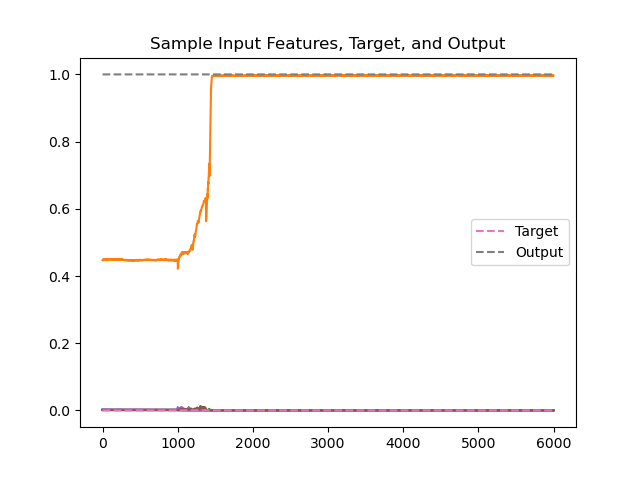

In [52]:
k = 0

input = inputs[k].numpy().T

target = targets[k].numpy().T
output = outputs[0][k].detach().cpu().numpy().T

# # Plot input features

plt.close()
for y in input:
    plt.plot(y)
plt.plot(target, label='Target', linestyle='--')
plt.plot(output, label='Output', linestyle='--')

plt.legend()
plt.title("Sample Input Features, Target, and Output")
plt.show()

In [53]:
for k in range(len(outputs)):
    if outputs[0][k].sum() > 0:
        print(k)

0
1


In [46]:
outputs[0].sum()

tensor(0)